In [1]:
import sys
print(sys.executable)

/home/ubuntu/ExamenBloc2/.venv/bin/python3


# Exploration, nettoyage des données

In [2]:
"""
Configuration des chemins pour le notebook Jupyter
"""
from pathlib import Path  # Pour manipuler les chemins de fichiers de façon indépendante du système d'exploitation
import json                # Pour lire/écrire des fichiers JSON
import math                # Fournit des fonctions mathématiques (ex: arrondis, contrôle de valeurs)
import pandas as pd        # Librairie pour l'analyse et la manipulation de données tabulaires
import numpy as np         # Gestion avancée des tableaux et des valeurs manquantes (np.nan)
import matplotlib.pyplot as plt  # Visualisation de données

# ------------------------------------------------------------------------
# Définition des chemins de projet
# ------------------------------------------------------------------------

# PROJECT_DIR : dossier racine du projet (notebook considéré comme dans un sous-dossier)
PROJECT_DIR = Path.cwd().parent  # chemin du notebook en cours d'exécution

# DATA_DIR : dossier principal pour toutes les données
DATA_DIR = PROJECT_DIR / "data"

# RAW_DIR : dossier pour les données brutes
RAW_DIR = DATA_DIR / "raw"

# PROCESSED_DIR : dossier pour les données nettoyées
PROCESSED_DIR = DATA_DIR / "processed"

# Dataset brut (JSON Lines : 1 JSON par ligne)
RAW_JSONL_PATH = RAW_DIR / "orders_events.jsonl"

# Dataset nettoyé (CSV)
CLEAN_CSV_PATH = PROCESSED_DIR / "orders_clean.csv"

# ------------------------------------------------------------------------
# Vérification et création des dossiers si nécessaire
# ------------------------------------------------------------------------
for folder in [DATA_DIR, RAW_DIR, PROCESSED_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------------
# Affichage des chemins pour vérification
# ------------------------------------------------------------------------
print("Chemins configurés :")
print(f"Data folder      : {DATA_DIR}")
print(f"Raw data folder  : {RAW_DIR}")
print(f"Raw data path    : {RAW_JSONL_PATH}")
print(f"Processed folder : {PROCESSED_DIR}")




Chemins configurés :
Data folder      : /home/ubuntu/ExamenBloc2/data
Raw data folder  : /home/ubuntu/ExamenBloc2/data/raw
Raw data path    : /home/ubuntu/ExamenBloc2/data/raw/orders_events.jsonl
Processed folder : /home/ubuntu/ExamenBloc2/data/processed


In [3]:
with RAW_JSONL_PATH.open('r', encoding='utf-8') as f: # On ouvre le fichier brut
    lines = f.read().splitlines() # On lit toutes les lignes (une ligne = un JSON)
print (lines[0]) # Affiche la première ligne pour vérification
print (len(lines)) # Affiche le nombre total de lignes pour vérification

{"event_id": "4421d292-0f86-4453-bab9-995256885cca", "event_time": "2026-01-08T17:59:18.973023Z", "order_id": "ORD-00563", "customer": {"customer_id": "CUST-0500", "country": "DE"}, "order": {"device": "tablet", "channel": "email", "main_category": "electronics", "n_items": 4, "basket_value": 193.86, "shipping_fee": 0.0, "discount": 0.0, "order_total": 193.86, "is_returned": 0}}
4050


In [4]:
#Lecture des données JSON Lines dans une liste de dictionnaires
data = [json.loads(line) for line in lines]
print(f"Nombre total d'enregistrements chargés : {len(data)}")  # Affiche le nombre total d'enregistrements chargés

Nombre total d'enregistrements chargés : 4050


# Conversion de la liste de dictionnaires en DataFrame

In [5]:
#Conversion de la liste de dictionnaires en DataFrame pandas pour une manipulation plus facile
df = pd.DataFrame(data)
print(f"Dimensions du DataFrame : {df.shape}")  # Affiche les dimensions du DataFrame (lignes, colonnes)
print("Aperçu des premières lignes du DataFrame :")
print(df.head())  # Affiche les premières lignes du DataFrame pour vérification


Dimensions du DataFrame : (4050, 5)
Aperçu des premières lignes du DataFrame :
                               event_id                   event_time  \
0  4421d292-0f86-4453-bab9-995256885cca  2026-01-08T17:59:18.973023Z   
1  798cbc4e-706e-460a-aa59-46e3549fc957  2026-01-21T08:14:19.037883Z   
2  6cf51636-aa0a-4ea6-be74-2bf2b170859b  2026-01-08T07:08:19.025822Z   
3  373b53a7-a484-459d-a157-5426cd99b979  2026-01-10T08:46:19.012009Z   
4  002c11e5-c0b6-4004-ad00-1b981537a126  2026-01-15T16:58:19.023840Z   

    order_id                                       customer  \
0  ORD-00563  {'customer_id': 'CUST-0500', 'country': 'DE'}   
1  ORD-03012  {'customer_id': 'CUST-0458', 'country': 'ES'}   
2  ORD-04779  {'customer_id': 'CUST-0239', 'country': 'DE'}   
3  ORD-01318  {'customer_id': 'CUST-0180', 'country': 'IT'}   
4  ORD-03652  {'customer_id': 'CUST-0171', 'country': 'ES'}   

                                               order  
0  {'device': 'tablet', 'channel': 'email', 'main...  

In [6]:
# Affichage des types de données pour chaque colonne
print("Types de données des colonnes :")
print(df.dtypes)
print(df.columns)

Types de données des colonnes :
event_id      object
event_time    object
order_id      object
customer      object
order         object
dtype: object
Index(['event_id', 'event_time', 'order_id', 'customer', 'order'], dtype='object')


# Aplatissement des colonnes imbriquées (si nécessaire)

In [7]:
def flatten_json_columns(df):
    """
    Aplatit automatiquement toutes les colonnes contenant des dictionnaires.
    Args:
        df (pd.DataFrame): DataFrame avec éventuellement des colonnes de type dict
    Returns:
        pd.DataFrame: DataFrame aplati
    """
    import pandas as pd 
    df_flat = df.copy()
    for col in df_flat.columns:
        # Vérifie si la colonne contient des dictionnaires (au moins une ligne)
        if df_flat[col].apply(lambda x: isinstance(x, dict)).any():
            # Aplatit la colonne
            normalized = pd.json_normalize(df_flat[col])
            # Renomme les colonnes avec un préfixe pour éviter les collisions
            normalized.columns = [f"{col}_{subcol}" for subcol in normalized.columns]
            # Supprime la colonne originale et joint les nouvelles colonnes aplaties
            df_flat = df_flat.drop(columns=[col]).join(normalized)
    return df_flat


In [8]:
# Applique l'aplatissement des colonnes JSON
df_flat = flatten_json_columns(df)
print(f"Dimensions du DataFrame aplati : {df_flat.shape}")  # Affiche les dimensions du DataFrame aplati
print("Aperçu des premières lignes du DataFrame aplati :")
print(df_flat.head())  # Affiche les premières lignes du DataFrame aplati pour vérification
print("Types de données des colonnes :")
print(df_flat.dtypes)

Dimensions du DataFrame aplati : (4050, 14)
Aperçu des premières lignes du DataFrame aplati :
                               event_id                   event_time  \
0  4421d292-0f86-4453-bab9-995256885cca  2026-01-08T17:59:18.973023Z   
1  798cbc4e-706e-460a-aa59-46e3549fc957  2026-01-21T08:14:19.037883Z   
2  6cf51636-aa0a-4ea6-be74-2bf2b170859b  2026-01-08T07:08:19.025822Z   
3  373b53a7-a484-459d-a157-5426cd99b979  2026-01-10T08:46:19.012009Z   
4  002c11e5-c0b6-4004-ad00-1b981537a126  2026-01-15T16:58:19.023840Z   

    order_id customer_customer_id customer_country order_device order_channel  \
0  ORD-00563            CUST-0500               DE       tablet         email   
1  ORD-03012            CUST-0458               ES       tablet         email   
2  ORD-04779            CUST-0239               DE       mobile         email   
3  ORD-01318            CUST-0180               IT       tablet           ads   
4  ORD-03652            CUST-0171               ES       mobile     

# Rapport rapide NA + valeurs uniques

In [9]:
# isna() crée un tableau booléen : True si la valeur est manquante (NaN), False sinon
# sum() sur des booléens compte les True (True=1, False=0)
na_count = df_flat.isna().sum()

# mean() sur booléens donne le pourcentage (car True=1, False=0)
# *100 pour convertir en pourcentage
na_pct = df_flat.isna().mean() * 100

# On construit un petit DataFrame de synthèse avec le nombre et le % de NA
na_report = pd.DataFrame({
    "na_count": na_count,           # nombre de NA par colonne
    "na_pct": na_pct.round(2)       # % de NA par colonne (arrondi à 2 décimales)
})

# On trie pour voir les colonnes les plus problématiques en premier
na_report = na_report.sort_values("na_count", ascending=False)

# On affiche le rapport
print(na_report)

# On liste quelques colonnes catégorielles probables (texte)
cat_cols = ["customer_country", "order_device", "order_channel", "order_main_category"]

# Pour chaque colonne catégorielle existante, on affiche :
# - le nombre de valeurs uniques
# - les 20 modalités les plus fréquentes
for col in cat_cols:
    if col in df_flat.columns:                          # on vérifie que la colonne existe
        print(f"\n--- Colonne: {col} ---")
        print("Nombre de valeurs uniques :", df_flat[col].nunique(dropna=False))  # dropna=False compte aussi NaN comme une valeur
        display(df_flat[col].value_counts(dropna=False).head(20))                # top 20 modalités


                      na_count  na_pct
order_channel              124    3.06
order_discount              71    1.75
order_id                     0    0.00
customer_customer_id         0    0.00
event_id                     0    0.00
event_time                   0    0.00
order_device                 0    0.00
customer_country             0    0.00
order_n_items                0    0.00
order_main_category          0    0.00
order_basket_value           0    0.00
order_shipping_fee           0    0.00
order_order_total            0    0.00
order_is_returned            0    0.00

--- Colonne: customer_country ---
Nombre de valeurs uniques : 5


customer_country
IT    826
BE    816
FR    810
ES    803
DE    795
Name: count, dtype: int64


--- Colonne: order_device ---
Nombre de valeurs uniques : 3


order_device
tablet     1390
mobile     1330
desktop    1330
Name: count, dtype: int64


--- Colonne: order_channel ---
Nombre de valeurs uniques : 6


order_channel
affiliate    836
direct       786
email        781
ads          767
seo          756
None         124
Name: count, dtype: int64


--- Colonne: order_main_category ---
Nombre de valeurs uniques : 5


order_main_category
fashion        853
sports         830
electronics    805
home           785
beauty         777
Name: count, dtype: int64

# Nettoyage léger des colonnes texte (strip / lower / upper)

In [10]:
# On définit les colonnes texte qu'on veut normaliser
# Objectif : éviter des différences artificielles ("Mobile" vs "mobile" vs " mobile ")
text_cols = [
    "event_id",
    "order_id",
    "customer_customer_id",
    "customer_country",
    "order_device",
    "order_channel",
    "order_main_category"
]

# On boucle sur chaque colonne
for col in text_cols:
    if col in df_flat.columns:                            # on s'assure que la colonne est bien présente
        df_flat[col] = df_flat[col].astype("string")      # "string" pandas gère mieux les NA que object classique
        df_flat[col] = df_flat[col].str.strip()           # strip() supprime les espaces au début et à la fin

        # On met en minuscules pour homogénéiser certaines catégories
        # (pas event_id / order_id / customer_id, car ce sont des identifiants)
        if col not in ["event_id", "order_id", "customer_customer_id", "customer_country"]:
            df_flat[col] = df_flat[col].str.lower()       # lower() met le texte en minuscules

# Pour le pays, on préfère des codes ISO en MAJ (DE, ES, IT)
if "customer_country" in df_flat.columns:
    df_flat["customer_country"] = df_flat["customer_country"].str.upper()  # upper() met en majuscules

print(df_flat.dtypes)
print(df_flat.head(10))

event_id                string[python]
event_time                      object
order_id                string[python]
customer_customer_id    string[python]
customer_country        string[python]
order_device            string[python]
order_channel           string[python]
order_main_category     string[python]
order_n_items                    int64
order_basket_value             float64
order_shipping_fee             float64
order_discount                 float64
order_order_total              float64
order_is_returned                int64
dtype: object
                               event_id                   event_time  \
0  4421d292-0f86-4453-bab9-995256885cca  2026-01-08T17:59:18.973023Z   
1  798cbc4e-706e-460a-aa59-46e3549fc957  2026-01-21T08:14:19.037883Z   
2  6cf51636-aa0a-4ea6-be74-2bf2b170859b  2026-01-08T07:08:19.025822Z   
3  373b53a7-a484-459d-a157-5426cd99b979  2026-01-10T08:46:19.012009Z   
4  002c11e5-c0b6-4004-ad00-1b981537a126  2026-01-15T16:58:19.023840Z   
5  6ed2c

# Conversion des types de données du DataFrame

In [11]:
import pandas as pd

df_flat_converted = pd.DataFrame()  # Nouveau DataFrame pour les données converties
# ======================================================
# Conversion des colonnes d'identifiants
# → utilisation du type 'string' pandas (plus robuste que 'object')
# ======================================================
df_flat_converted["event_id"] = df_flat["event_id"].astype("string")
df_flat_converted["order_id"] = df_flat["order_id"].astype("string")
df_flat_converted["customer_customer_id"] = df_flat["customer_customer_id"].astype("string")

# ======================================================
# Conversion de la colonne temporelle
# → transformation de la date ISO 8601 en datetime avec timezone UTC
# pd.to_datetime transforme une colonne texte en type datetime utilisable (tri, extraction d'année, etc.)
# errors="coerce" : si un format n'est pas convertible, pandas met NaT (équivalent datetime de NaN)
# utc=True : force la timezone UTC (cohérent avec le suffixe "Z" dans tes dates)
# ======================================================
df_flat_converted["event_time"] = pd.to_datetime(df_flat["event_time"], errors="coerce", utc=True)

# ======================================================
# Conversion des colonnes catégorielles
# → type 'category' pour réduire la mémoire et faciliter les analyses
# ======================================================
categorical_cols = [
    "customer_country",
    "order_device",
    "order_channel",
    "order_main_category"
]

df_flat_converted[categorical_cols] = df_flat[categorical_cols].astype("category")

# ======================================================
# Conversion des colonnes numériques entières
# → nombre d’articles dans la commande
# ======================================================
df_flat_converted["order_n_items"] = df_flat["order_n_items"].astype("int64")

# ======================================================
# Conversion des colonnes numériques décimales
# → montants financiers (float)
# ======================================================
numeric_cols = [
    "order_basket_value",
    "order_shipping_fee",
    "order_discount",
    "order_order_total"
]

df_flat_converted[numeric_cols] = df_flat[numeric_cols].astype("float64")

# ======================================================
# Conversion de l’indicateur de retour
# → transformation de 0 / 1 en booléen (False / True)
# ======================================================
df_flat_converted["order_is_returned"] = df_flat["order_is_returned"].astype("bool")

# ======================================================
# Vérification finale des types de données
# ======================================================
print(df_flat_converted.dtypes)
print(df_flat_converted.head())


event_id                     string[python]
order_id                     string[python]
customer_customer_id         string[python]
event_time              datetime64[ns, UTC]
customer_country                   category
order_device                       category
order_channel                      category
order_main_category                category
order_n_items                         int64
order_basket_value                  float64
order_shipping_fee                  float64
order_discount                      float64
order_order_total                   float64
order_is_returned                      bool
dtype: object
                               event_id   order_id customer_customer_id  \
0  4421d292-0f86-4453-bab9-995256885cca  ORD-00563            CUST-0500   
1  798cbc4e-706e-460a-aa59-46e3549fc957  ORD-03012            CUST-0458   
2  6cf51636-aa0a-4ea6-be74-2bf2b170859b  ORD-04779            CUST-0239   
3  373b53a7-a484-459d-a157-5426cd99b979  ORD-01318            CUST-018

# Gestion des doublons (duplicated + drop_duplicates)

In [12]:
# Doublons exacts (toutes colonnes)
# duplicated() renvoie une Series booléenne :
# True si la ligne est un doublon exact d'une ligne précédente
# sum() compte le nombre de True => le nombre de doublons
nb_dup_exact = df_flat_converted.duplicated().sum()

# On affiche le nombre de doublons exacts
print("Doublons exacts (toutes colonnes) :", nb_dup_exact)

# drop_duplicates() supprime les doublons
# keep="first" garde la première occurrence et supprime les suivantes
df_flat_converted_unique = df_flat_converted.drop_duplicates(keep="first")

# On affiche la nouvelle taille
print("Dimensions après suppression doublons exacts :", df_flat_converted_unique.shape)


Doublons exacts (toutes colonnes) : 50
Dimensions après suppression doublons exacts : (4000, 14)


# Doublons métier sur event_id (garder le plus récent)

In [13]:
# duplicated(subset=["event_id"]) détecte les doublons uniquement sur event_id
# si event_id doit être unique, on veut n'en garder qu'un seul
nb_dup_event = df_flat_converted_unique.duplicated(subset=["event_id"]).sum()
print("Doublons sur event_id :", nb_dup_event)

# Pour garder l'événement le plus récent, on trie d'abord par event_time
# sort_values("event_time") met les plus anciennes en haut, les plus récentes en bas
df_flat_converted_unique = df_flat_converted_unique.sort_values("event_time")

# drop_duplicates(..., keep="last") garde la dernière occurrence (donc la plus récente après tri)
df_flat_converted_unique = df_flat_converted_unique.drop_duplicates(subset=["event_id"], keep="last")

# On affiche la taille finale après ce dédoublonnage
print("Dimensions après dédoublonnage event_id :", df_flat_converted_unique.shape)


Doublons sur event_id : 0
Dimensions après dédoublonnage event_id : (4000, 14)


# Contrôles de cohérence métier

In [14]:
# On crée un dictionnaire pour stocker des "compteurs" d'erreurs/valeurs suspectes
checks = {}

# (1) order_n_items négatif => suspect
checks["order_n_items_negative"] = (df_flat_converted_unique["order_n_items"] < 0).sum()

# (2) Montants négatifs => suspect (à adapter si tu gères des avoirs/retours en négatif)
money_cols = ["order_basket_value", "order_shipping_fee", "order_discount", "order_order_total"]
for col in money_cols:
    checks[f"{col}_negative"] = (df_flat_converted_unique[col] < 0).sum()

# (3) event_time manquant => difficilement exploitable
checks["event_time_missing"] = df_flat_converted_unique["event_time"].isna().sum()

# On convertit le dict en DataFrame pour l'afficher joliment
print(pd.DataFrame.from_dict(checks, orient="index", columns=["count"]))


                             count
order_n_items_negative           0
order_basket_value_negative      0
order_shipping_fee_negative      0
order_discount_negative          0
order_order_total_negative       0
event_time_missing               0


# Gestion des valeurs manquantes (NaN)

In [15]:
# Fill NA catégoriels (mode ou valeur “unknown”)
df_flat_converted_unique_without_na = df_flat_converted_unique.copy()  # Copie pour remplir les NA
# Pour customer_country, si manquant => "UN" (Unknown)
# Creer la nouvelle categorie 
if "customer_country" in df_flat_converted_unique.columns:
    df_flat_converted_unique["customer_country"] = (
        df_flat_converted_unique["customer_country"]
        .cat.add_categories(["UN"])
        .fillna("UN")
    )

if "customer_country" in df_flat_converted_unique.columns:
    df_flat_converted_unique_without_na["customer_country"] = df_flat_converted_unique["customer_country"].fillna("UN")  # fillna remplace NA par "UN"

# Pour device/channel/category, si manquant => la mode (valeur la plus fréquente)
for col in ["order_device", "order_channel", "order_main_category"]:
    if col in df_flat_converted_unique.columns:
        mode_value = df_flat[col].mode()[0]  # mode() renvoie une Series, on prend la première valeur
        df_flat_converted_unique_without_na[col] = df_flat_converted_unique[col].fillna(mode_value)  # fillna remplace NA par la mode


In [16]:
# Fill NA numériques (stratégie simple et robuste)
# (1) shipping_fee et discount :
# Si absent, il est souvent raisonnable de considérer 0 (pas de frais / pas de remise)
for col in ["order_shipping_fee", "order_discount"]:
    if col in df_flat_converted_unique.columns:
        df_flat_converted_unique_without_na[col] = df_flat_converted_unique[col].fillna(0.0)  # remplace NA par 0.0 (float)

# (2) order_n_items :
# On remplace par la médiane (plus robuste que la moyenne si outliers)
if "order_n_items" in df_flat_converted_unique.columns:
    median_items = df_flat_converted_unique["order_n_items"].median()     # calcule la médiane
    df_flat_converted_unique_without_na["order_n_items"] = df_flat_converted_unique["order_n_items"].fillna(median_items)  # remplace NA par médiane
    df_flat_converted_unique_without_na["order_n_items"] = df_flat_converted_unique["order_n_items"].round().astype(int)   # arrondi puis cast en int

# (3) order_basket_value :
# Si absent, on remplace par la médiane (stratégie baseline)
if "order_basket_value" in df_flat_converted_unique.columns:
    median_basket = df_flat_converted_unique["order_basket_value"].median()                  # calcule médiane
    df_flat_converted_unique_without_na["order_basket_value"] = df_flat_converted_unique["order_basket_value"].fillna(median_basket)  # remplace NA

print (df_flat_converted_unique_without_na.dtypes)
print (df_flat_converted_unique_without_na.head())
print (df_flat_converted_unique_without_na.info())

event_id                     string[python]
order_id                     string[python]
customer_customer_id         string[python]
event_time              datetime64[ns, UTC]
customer_country                   category
order_device                       category
order_channel                      category
order_main_category                category
order_n_items                         int64
order_basket_value                  float64
order_shipping_fee                  float64
order_discount                      float64
order_order_total                   float64
order_is_returned                      bool
dtype: object
                                  event_id   order_id customer_customer_id  \
3246  924d78f0-8ead-4a1d-960a-444e1ce458fa  ORD-03149            CUST-0037   
1089  50bf179d-e4ed-4d20-b995-dfaabeb633fe  ORD-03305            CUST-0006   
3323  36df23d9-f1ec-433e-b539-24bce867f5a3  ORD-04082            CUST-0202   
3694  8c60222f-93a7-4cb8-b54f-cf073386ff1b  ORD-00440     

# Cohérence total = basket + shipping - discount

In [17]:
# On calcule un total attendu à partir des composantes
# (basket_value + shipping_fee - discount)
df_flat_converted_unique_without_na["order_total_expected"] = (
    df_flat_converted_unique_without_na["order_basket_value"]          # valeur panier
    + df_flat_converted_unique_without_na["order_shipping_fee"]        # frais de livraison
    - df_flat_converted_unique_without_na["order_discount"]            # remise
)

# On calcule l'écart entre le total présent et le total attendu
df_flat_converted_unique_without_na["order_total_delta"] = (
    df_flat_converted_unique_without_na["order_order_total"] 
    - df_flat_converted_unique_without_na["order_total_expected"]
)
# On définit une tolérance d'arrondi (ex: 1 centime)
tolerance = 0.01

# On crée un flag : True si incohérence (écart > tolérance), False sinon
df_flat_converted_unique_without_na["order_total_inconsistent"] = df_flat_converted_unique_without_na["order_total_delta"].abs() > tolerance

# On compte combien de order_order_total sont manquants avant correction
missing_total_before = df_flat_converted_unique_without_na["order_order_total"].isna().sum()
print("order_order_total manquants (avant fill) :", missing_total_before)

# Si order_order_total est NA, on le remplace par le total attendu calculé
df_flat_converted_unique_without_na["order_order_total"] = df_flat_converted_unique_without_na["order_order_total"].fillna(df_flat_converted_unique_without_na["order_total_expected"])
# On affiche combien de lignes sont incohérentes
print("Nombre de lignes avec total incohérent :", df_flat_converted_unique_without_na["order_total_inconsistent"].sum())

# On montre quelques exemples incohérents pour investigation
print(df_flat_converted_unique_without_na[df_flat_converted_unique_without_na["order_total_inconsistent"]].head(20))

order_order_total manquants (avant fill) : 0
Nombre de lignes avec total incohérent : 28
                                  event_id   order_id customer_customer_id  \
3811  ef3152e6-4c8b-4165-b976-8bc0b129f223  ORD-02570            CUST-0254   
1443  efc90039-8981-4239-a7ec-2d84e62b80a2  ORD-00954            CUST-0456   
1280  53dbcc00-a8e8-4637-beb3-7b4d337a30d9  ORD-04461            CUST-0141   
2563  ee866e1f-37e9-4ef4-b6d1-ada229541929  ORD-01883            CUST-0086   
1360  92a28211-394a-4c6f-b689-6e3bae1c1c1a  ORD-03794            CUST-0384   
3893  b1bd0a4f-844d-4ac1-bdd0-1575d1d0c357  ORD-00743            CUST-0394   
1234  884e2cee-6803-4732-9b59-6f06e6799191  ORD-03696            CUST-0196   
898   b68388d6-b572-4574-8f24-dde47174c47e  ORD-00251            CUST-0310   
3030  2d0e27dc-52ce-408d-94b0-b488ea8575d7  ORD-00354            CUST-0454   
2737  ef16e27f-f81c-47ab-ad19-c6ee07d821ba  ORD-02704            CUST-0543   
1317  deca719b-c768-4cf5-8538-f9fb6974f1b0  ORD-01221

# Apply / Lambda (exemples concrets)

In [18]:

df_final =df_flat_converted_unique_without_na.copy()  # Copie pour transformations finales
# Extraire des features temporelles
# dt.year / dt.month / dt.day / dt.hour :
# fonctionne uniquement si event_time est bien en datetime
df_final["event_year"] = df_final["event_time"].dt.year      # extrait l'année
df_final["event_month"] = df_final["event_time"].dt.month    # extrait le mois
df_final["event_day"] = df_final["event_time"].dt.day        # extrait le jour
df_final["event_hour"] = df_final["event_time"].dt.hour      # extrait l'heure

# On affiche quelques lignes pour vérifier
print(df_final[["event_time", "event_year", "event_month", "event_day", "event_hour"]].head(10))
print(df_final.head(10))

                           event_time  event_year  event_month  event_day  \
3246 2025-12-31 15:53:19.021865+00:00        2025           12         31   
1089 2025-12-31 15:57:19.033003+00:00        2025           12         31   
3323 2025-12-31 15:58:19.027022+00:00        2025           12         31   
3694 2025-12-31 16:06:18.971905+00:00        2025           12         31   
3915 2025-12-31 16:12:19.035292+00:00        2025           12         31   
3190 2025-12-31 16:15:18.996741+00:00        2025           12         31   
1191 2025-12-31 16:27:19.029491+00:00        2025           12         31   
2358 2025-12-31 16:35:19.041179+00:00        2025           12         31   
3486 2025-12-31 16:38:18.977270+00:00        2025           12         31   
621  2025-12-31 16:41:19.002645+00:00        2025           12         31   

      event_hour  
3246          15  
1089          15  
3323          15  
3694          16  
3915          16  
3190          16  
1191          16  


# Apply + lambda sur lignes : prix moyen par article

In [19]:
# On crée une nouvelle colonne "price_per_item"
# = order_basket_value / order_n_items
# On utilise apply + lambda pour appliquer la fonction ligne par ligne
df_final["price_per_item"] = df_final.apply(
    lambda row: row["order_basket_value"] / row["order_n_items"] if row["order_n_items"] > 0 else np.nan,
    axis=1  # axis=1 signifie qu'on applique la fonction sur les lignes
)
# On affiche quelques lignes pour vérifier
print(df_final[["order_basket_value", "order_n_items", "price_per_item"]].head(10))

      order_basket_value  order_n_items  price_per_item
3246              498.90              8       62.362500
1089              491.11              2      245.555000
3323              287.46              8       35.932500
3694               95.67              8       11.958750
3915              364.16              5       72.832000
3190              258.06              3       86.020000
1191              112.74              5       22.548000
2358              249.75              4       62.437500
3486              389.24              7       55.605714
621               121.61              5       24.322000


# Vérif NA finale + types + aperçu

In [20]:
print("Vérification finale des NA :")
print(df_final.isna().sum())    # Affiche le nombre de NA par colonne
print("Types de données finaux :")
print(df_final.dtypes)          # Affiche les types de données finaux
print("Vérifie si event_id est unique (souvent attendu)")
print(df_final["event_id"].nunique() == df_final.shape[0])  # Vérifie si tous les event_id sont uniques
print("Aperçu final des données :")
print(df_final.head())          # Affiche les premières lignes du DataFrame final
print(f"Dimensions finales du DataFrame : {df_final.shape}")  # Affiche les dimensions finales du DataFrame

Vérification finale des NA :
event_id                    0
order_id                    0
customer_customer_id        0
event_time                  0
customer_country            0
order_device                0
order_channel               0
order_main_category         0
order_n_items               0
order_basket_value          0
order_shipping_fee          0
order_discount              0
order_order_total           0
order_is_returned           0
order_total_expected        0
order_total_delta           0
order_total_inconsistent    0
event_year                  0
event_month                 0
event_day                   0
event_hour                  0
price_per_item              0
dtype: int64
Types de données finaux :
event_id                         string[python]
order_id                         string[python]
customer_customer_id             string[python]
event_time                  datetime64[ns, UTC]
customer_country                       category
order_device                    

# Export du DataFrame final nettoyé (CSV et Parquet) dans PROCESSED_DIR

In [21]:
# Chemin du fichier CSV
processed_csv_path = PROCESSED_DIR / "orders_events_cleaned.csv"
# Export en CSV (index=False pour ne pas inclure l'index pandas)
df_final.to_csv(processed_csv_path, index=False)
print(f"DataFrame final exporté en CSV vers : {processed_csv_path}")
# Chemin du fichier Parquet
processed_parquet_path = PROCESSED_DIR / "orders_events_cleaned.parquet"
# Export en Parquet (index=False pour ne pas inclure l'index pandas)
df_final.to_parquet(processed_parquet_path, index=False)
print(f"DataFrame final exporté en Parquet vers : {processed_parquet_path}")

DataFrame final exporté en CSV vers : /home/ubuntu/ExamenBloc2/data/processed/orders_events_cleaned.csv
DataFrame final exporté en Parquet vers : /home/ubuntu/ExamenBloc2/data/processed/orders_events_cleaned.parquet


# Imports Matplotlib + réglages d’affichage

In [22]:
# On importe matplotlib.pyplot : c'est le module principal pour tracer des graphiques
import matplotlib.pyplot as plt

# On importe matplotlib.dates pour mieux formater les dates sur l'axe X (utile en time series)
import matplotlib.dates as mdates

# On affiche les graphiques "dans" le notebook (si tu es sur Jupyter)
%matplotlib inline

# On définit une taille par défaut des figures (évite d'avoir des plots trop petits)
# plt.rcParams["figure.figsize"] = (10, 5)

# On définit une résolution plus propre (utile si tu exportes des images)
# plt.rcParams["figure.dpi"] = 120

## Vue d’ensemble “EDA” (statistiques rapides)

In [23]:
# On liste les colonnes numériques (int/float) automatiquement
num_cols = df_final.select_dtypes(include=["number"]).columns

# On affiche les stats descriptives des colonnes numériques
# describe() calcule count, mean, std, min, quartiles, max
print(df_final[num_cols].describe().T)

# On liste les colonnes catégorielles (type category)
cat_cols = df_final.select_dtypes(include=["category"]).columns

# On affiche les colonnes catégorielles détectées
print("Colonnes catégorielles :", list(cat_cols))

# On calcule le taux global de retour (bool -> mean : True=1, False=0)
# mean() sur bool donne directement une proportion
return_rate = df_final["order_is_returned"].mean()

# On affiche le taux global de retour en %
print(f"Taux global de retour : {return_rate*100:.2f}%")

                       count         mean         std         min  \
order_n_items         4000.0     4.476500    2.305380     1.00000   
order_basket_value    4000.0   257.358575  141.381038    10.01000   
order_shipping_fee    4000.0     0.808120    2.103014     0.00000   
order_discount        4000.0     4.769337    8.502663     0.00000   
order_order_total     4000.0   253.357370  140.591285     1.00000   
order_total_expected  4000.0   253.397357  140.637524   -12.28000   
order_total_delta     4000.0    -0.039987    1.067619   -29.44000   
event_year            4000.0  2025.987750    0.110013  2025.00000   
event_month           4000.0     1.134750    1.210148     1.00000   
event_day             4000.0    16.008250    8.934799     1.00000   
event_hour            4000.0    11.380000    6.912637     0.00000   
price_per_item        4000.0    89.900908   98.398280     1.29375   

                              25%         50%        75%      max  
order_n_items            2.000000 

## A) Exploration des variables numériques

### Histogramme : order_order_total (distribution)

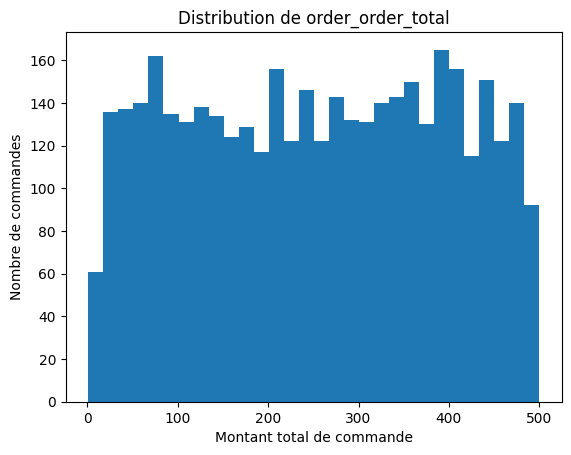

In [24]:
# On crée une nouvelle figure (un graphique indépendant)
plt.figure()

# On trace un histogramme des montants totaux
# bins=30 : nombre de "barres" (classes) dans l'histogramme
# dropna() : par sécurité (même si tu n'as plus de NA)
plt.hist(df_final["order_order_total"].dropna(), bins=30)

# On ajoute un titre au graphique
plt.title("Distribution de order_order_total")

# On nomme l'axe X (ce que représente la variable)
plt.xlabel("Montant total de commande")

# On nomme l'axe Y (nombre d'observations dans chaque intervalle)
plt.ylabel("Nombre de commandes")

# On affiche le graphique
plt.show()

# Analyse (quoi regarder) :
# Distribution “longue queue” (beaucoup de petites commandes + quelques énormes)
# Si tu vois des “pics” → possible effet de pricing (paliers), ou arrondis

### Boxplot : repérer les outliers sur le total

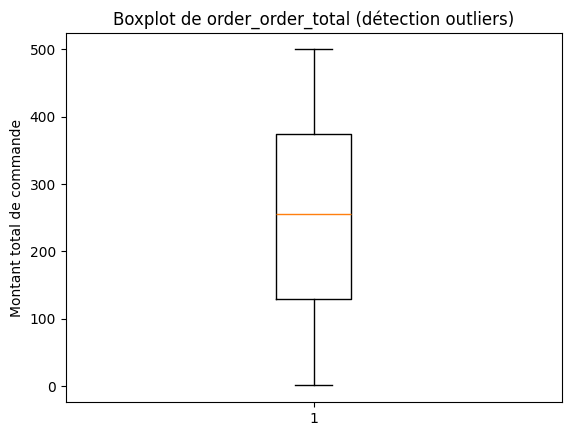

In [25]:
# On crée une figure
plt.figure()

# Le boxplot montre médiane, quartiles et valeurs extrêmes
plt.boxplot(df_final["order_order_total"].dropna())

# Titre
plt.title("Boxplot de order_order_total (détection outliers)")

# Label axe Y (car boxplot vertical par défaut)
plt.ylabel("Montant total de commande")

# Affichage
plt.show()

# Analyse :
# Les points extrêmes sont des outliers potentiels (fraude, gros paniers B2B, erreurs)
# Un boxplot très “écrasé” + très longue moustache → distribution très asymétrique

### Histogramme : price_per_item

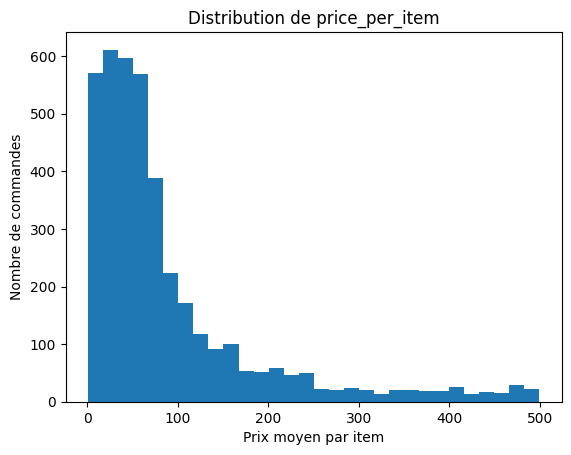

In [27]:
# On crée une figure
plt.figure()

# On trace la distribution du prix unitaire moyen
plt.hist(df_final["price_per_item"].dropna(), bins=30)

# Titre
plt.title("Distribution de price_per_item")

# Axe X
plt.xlabel("Prix moyen par item")

# Axe Y
plt.ylabel("Nombre de commandes")

# Affiche
plt.show()

# Analyse :
# Très intéressant pour détecter des valeurs anormales (prix unitaire très haut/bas)
# Si distribution bimodale → peut refléter des catégories très différentes (ex : electronics vs fashion)

### Bar chart : distribution de order_n_items

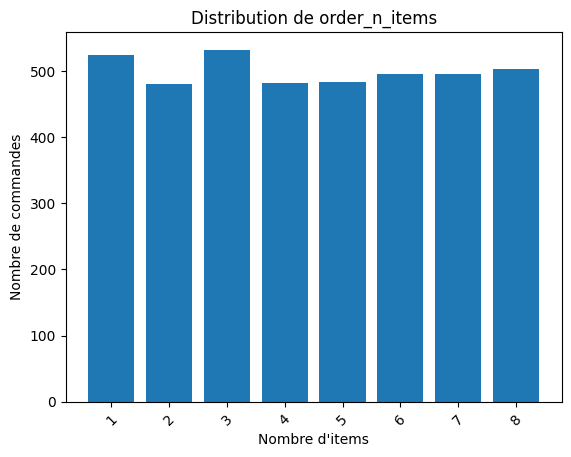

In [29]:
# On calcule la fréquence de chaque valeur de n_items
# value_counts() compte combien de fois chaque valeur apparaît
counts_items = df_final["order_n_items"].value_counts().sort_index()

# On crée une figure
plt.figure()

# On trace un bar chart (axe X = nb items, axe Y = fréquence)
plt.bar(counts_items.index.astype(str), counts_items.values)

# Titre
plt.title("Distribution de order_n_items")

# Axe X
plt.xlabel("Nombre d'items")

# Axe Y
plt.ylabel("Nombre de commandes")

# On incline un peu les labels si besoin (utile si beaucoup de valeurs)
plt.xticks(rotation=45)

# Affiche
plt.show()

# Analyse :
# Permet de voir si les commandes sont plutôt “petites” ou “grosses”
# Valeurs rares très hautes → vérifier si c’est normal

## B) Exploration des variables catégorielles

### Bar chart : répartition par pays

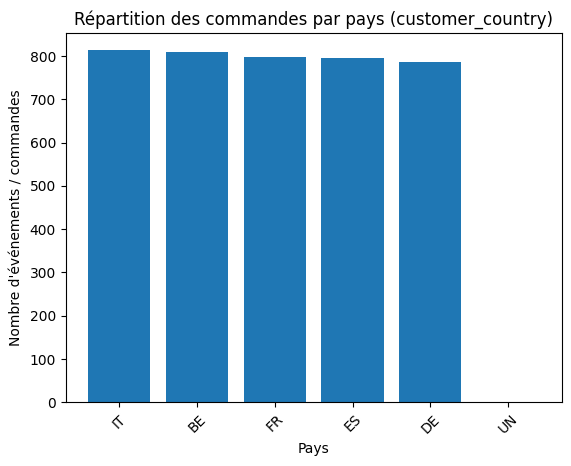

In [32]:
# On calcule la fréquence par pays
country_counts = df_final["customer_country"].value_counts()

# On crée une figure
plt.figure()

# On trace un bar chart (top pays)
plt.bar(country_counts.index.astype(str), country_counts.values)

# Titre
plt.title("Répartition des commandes par pays (customer_country)")

# Axe X
plt.xlabel("Pays")

# Axe Y
plt.ylabel("Nombre d'événements / commandes")

# Rotation des labels pour lisibilité
plt.xticks(rotation=45)

# Affiche
plt.show()

#Analyse :
#Tes marchés principaux (pays dominants)
#Un pays très faible peut indiquer un canal d’acquisition peu développé / segmentation

### Bar chart : device / channel / category (3 graphiques séparés)

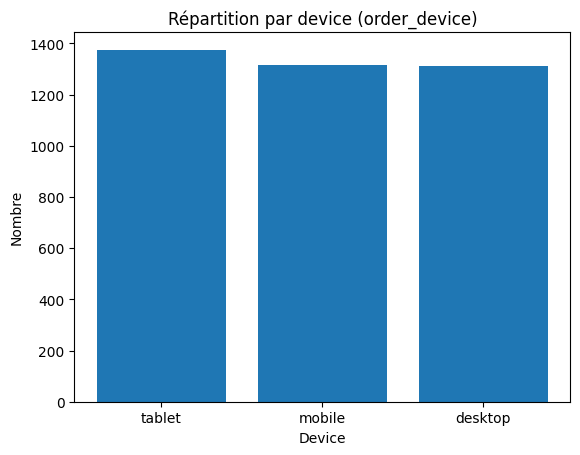

In [34]:
# Fréquences par device
device_counts = df_final["order_device"].value_counts()

# Figure
plt.figure()

# Bar chart
plt.bar(device_counts.index.astype(str), device_counts.values)

# Titre
plt.title("Répartition par device (order_device)")

# Labels
plt.xlabel("Device")
plt.ylabel("Nombre")

# Affichage
plt.show()


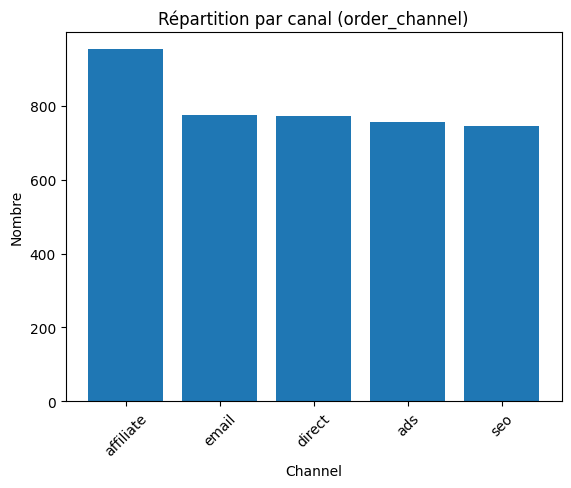

In [35]:
# Fréquences par channel
channel_counts = df_final["order_channel"].value_counts()

# Figure
plt.figure()

# Bar chart
plt.bar(channel_counts.index.astype(str), channel_counts.values)

# Titre
plt.title("Répartition par canal (order_channel)")

# Labels
plt.xlabel("Channel")
plt.ylabel("Nombre")

# Rotation (souvent utile)
plt.xticks(rotation=45)

# Affichage
plt.show()


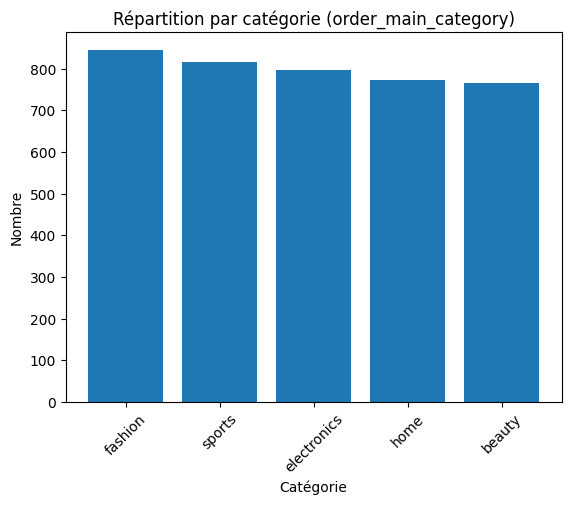

In [36]:
# Fréquences par catégorie
cat_counts = df_final["order_main_category"].value_counts()

# Figure
plt.figure()

# Bar chart
plt.bar(cat_counts.index.astype(str), cat_counts.values)

# Titre
plt.title("Répartition par catégorie (order_main_category)")

# Labels
plt.xlabel("Catégorie")
plt.ylabel("Nombre")

# Rotation pour lisibilité
plt.xticks(rotation=45)

# Affichage
plt.show()


In [ ]:
# Analyse :
# device/channel : structure acquisition + usages clients
# category : mix produit → impact direct sur panier moyen, retours, prix unitaire

## C) Analyse des retours (variable booléenne) par segment

### Taux de retour par catégorie

/tmp/ipykernel_32050/1341335560.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return_by_cat = df_final.groupby("order_main_category")["order_is_returned"].mean().sort_values(ascending=False)


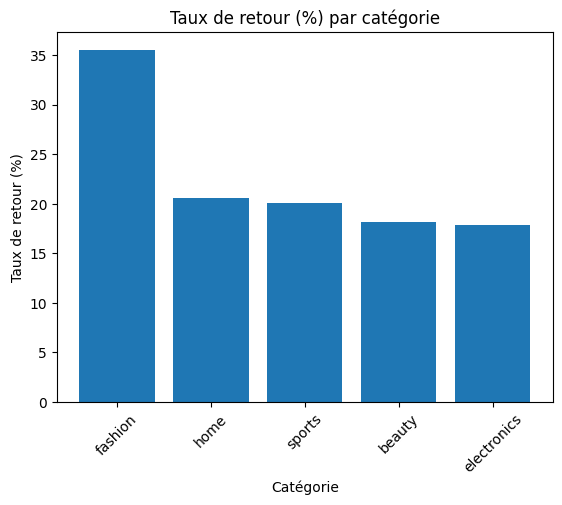

In [38]:
# groupby(...) regroupe les lignes par catégorie
# ["order_is_returned"].mean() calcule le taux de retour (True=1, False=0) pour chaque catégorie
return_by_cat = df_final.groupby("order_main_category")["order_is_returned"].mean().sort_values(ascending=False)

# Figure
plt.figure()

# Bar chart des taux (on multiplie par 100 pour obtenir un pourcentage)
plt.bar(return_by_cat.index.astype(str), return_by_cat.values * 100)

# Titre
plt.title("Taux de retour (%) par catégorie")

# Labels
plt.xlabel("Catégorie")
plt.ylabel("Taux de retour (%)")

# Rotation
plt.xticks(rotation=45)

# Affichage
plt.show()

# Analyse :
# Catégories avec retours élevés → souvent liées à taille/fit (fashion) ou qualité/perception
# Action possible : ajuster descriptifs, tailles, logistique, contrôle qualité

### Taux de retour par channel

/tmp/ipykernel_32050/1610040333.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return_by_channel = df_final.groupby("order_channel")["order_is_returned"].mean().sort_values(ascending=False)


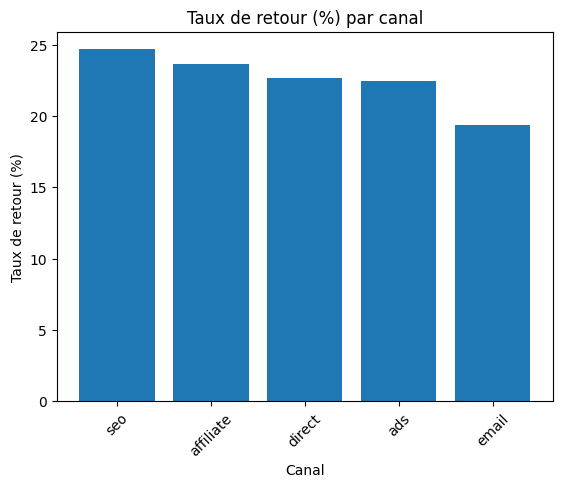

In [39]:
# Taux de retour par canal
return_by_channel = df_final.groupby("order_channel")["order_is_returned"].mean().sort_values(ascending=False)

# Figure
plt.figure()

# Bar chart en %
plt.bar(return_by_channel.index.astype(str), return_by_channel.values * 100)

# Titre
plt.title("Taux de retour (%) par canal")

# Labels
plt.xlabel("Canal")
plt.ylabel("Taux de retour (%)")

# Rotation
plt.xticks(rotation=45)

# Affichage
plt.show()

# Analyse :
# Un canal qui “vend mal” (retours élevés) peut indiquer : promesse marketing trop agressive, mauvaise qualification, etc.

## D) Analyse temporelle (time series)

### Événements par jour (volume)

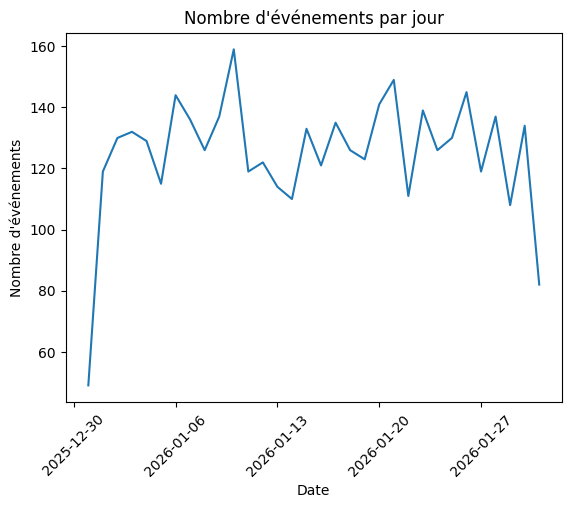

In [42]:
# On crée une série temporelle : on met event_time en index pour utiliser resample()
ts = df_final.set_index("event_time")

# resample("D") regroupe par jour (D = daily)
# size() compte le nombre de lignes par jour
events_per_day = ts.resample("D").size()

# Figure
plt.figure()

# Plot ligne (time series)
plt.plot(events_per_day.index, events_per_day.values)

# Titre
plt.title("Nombre d'événements par jour")

# Labels
plt.xlabel("Date")
plt.ylabel("Nombre d'événements")

# On formate les dates (1 tick par semaine par exemple)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

# Format d'affichage des dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# Rotation pour lisibilité
plt.xticks(rotation=45)

# Affichage
plt.show()

# Analyse :
# Tendance globale (hausse/baisse)
# Pics : campagnes marketing, promo, événements “spéciaux”
# Creux : week-ends (selon activité), bugs tracking, etc.


### Chiffre d’affaires (somme du total) par jour

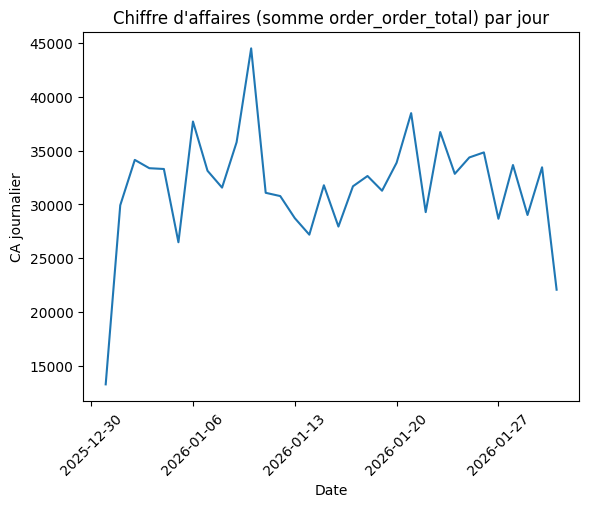

In [43]:
# On calcule la somme du total par jour
revenue_per_day = ts["order_order_total"].resample("D").sum()

# Figure
plt.figure()

# Plot ligne
plt.plot(revenue_per_day.index, revenue_per_day.values)

# Titre
plt.title("Chiffre d'affaires (somme order_order_total) par jour")

# Labels
plt.xlabel("Date")
plt.ylabel("CA journalier")

# Format dates (hebdo)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# Affichage
plt.show()

# Analyse :
# Compare CA vs volume : si CA monte mais volume stable → panier moyen augmente
# Pics CA sans pics volume → grosses commandes / catégories chères

## Patterns par heure (cycle journalier)

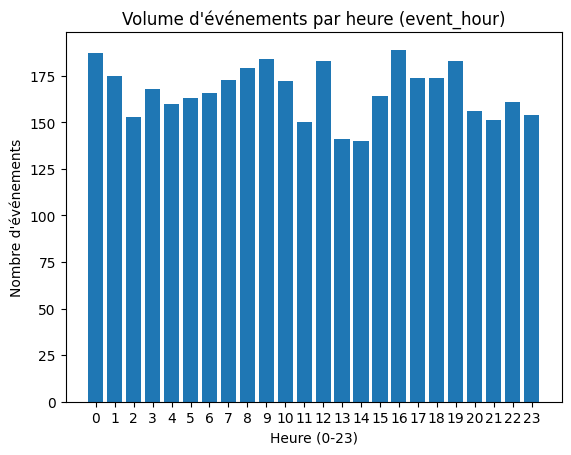

In [45]:
# On compte le nombre d'événements par heure (0 à 23)
# value_counts() compte les occurrences, sort_index() trie de 0 à 23
hour_counts = df_final["event_hour"].value_counts().sort_index()

# Figure
plt.figure()

# Bar chart
plt.bar(hour_counts.index.astype(str), hour_counts.values)

# Titre
plt.title("Volume d'événements par heure (event_hour)")

# Labels
plt.xlabel("Heure (0-23)")
plt.ylabel("Nombre d'événements")

# Affichage
plt.show()

# Analyse :
# Heures de pointe (trafic / achats)
# Si très concentré sur une tranche → ton “prime time” business


## E) Relations entre variables numériques (scatter)

### Scatter : panier vs nombre d’items

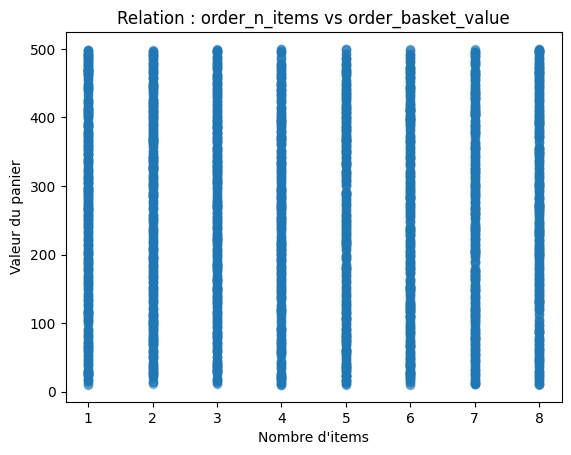

In [46]:
# Figure
plt.figure()

# Scatter plot :
# alpha rend les points un peu transparents pour mieux voir les zones denses
plt.scatter(df_final["order_n_items"], df_final["order_basket_value"], alpha=0.4)

# Titre
plt.title("Relation : order_n_items vs order_basket_value")

# Labels
plt.xlabel("Nombre d'items")
plt.ylabel("Valeur du panier")

# Affichage
plt.show()

# Analyse :
# Relation attendue : plus d’items → panier plus élevé
# Si tu vois des points “bizarres” (peu d’items mais panier énorme) → produits chers / anomalies

### Scatter : prix par item vs nombre d’items

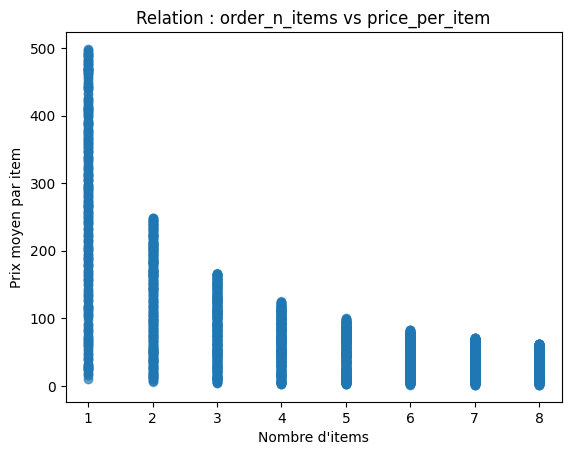

In [47]:
# Figure
plt.figure()

# Scatter
plt.scatter(df_final["order_n_items"], df_final["price_per_item"], alpha=0.4)

# Titre
plt.title("Relation : order_n_items vs price_per_item")

# Labels
plt.xlabel("Nombre d'items")
plt.ylabel("Prix moyen par item")

# Affichage
plt.show()

# Analyse :
# Souvent, plus d’items → prix moyen par item peut baisser (effet “panier mix”)
# Si prix par item extrêmement haut → vérifier catégories / tracking


## F) Corrélation (matrice) — 100% Matplotlib

### Heatmap corrélations (sans seaborn)

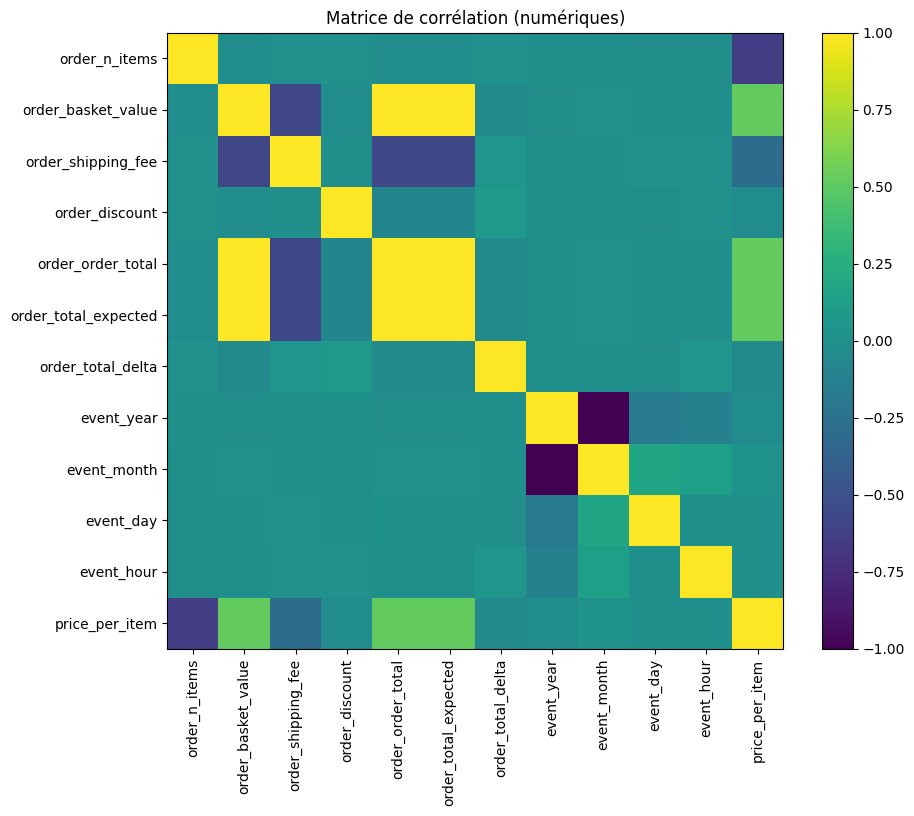

In [49]:
# On sélectionne uniquement les colonnes numériques pour corr()
num_cols = df_final.select_dtypes(include=["number"]).columns

# corr() calcule la corrélation (Pearson) entre colonnes numériques
corr = df_final[num_cols].corr()

# Figure
plt.figure(figsize=(10, 8))

# imshow affiche une matrice comme une image
plt.imshow(corr.values)

# On ajoute une barre de couleur (échelle des valeurs)
plt.colorbar()

# On configure les ticks X avec les noms de colonnes
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)

# On configure les ticks Y avec les noms de colonnes
plt.yticks(range(len(corr.index)), corr.index)

# Titre
plt.title("Matrice de corrélation (numériques)")

# Affichage
plt.show()

# Analyse :
# Corrélation forte attendue : order_order_total vs order_basket_value
# Corrélation négative possible : order_discount vs total (selon définition)
# Attention : corrélation ≠ causalité

## G) Segmentation “métier” : CA par catégorie (bar)

### Top catégories par CA

/tmp/ipykernel_32050/2400224848.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_cat = df_final.groupby("order_main_category")["order_order_total"].sum().sort_values(ascending=False)


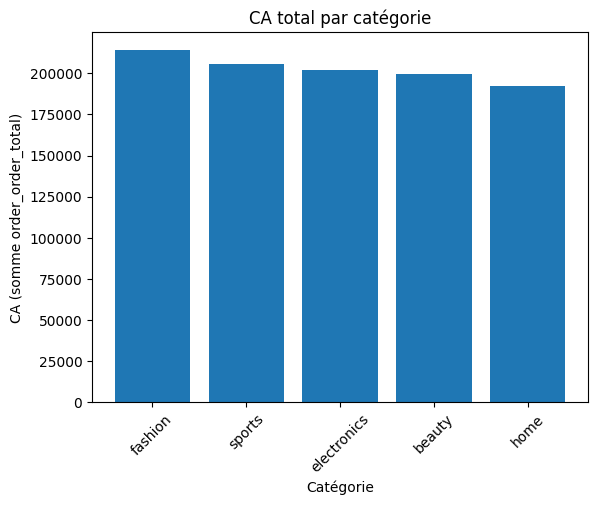

In [50]:
# On regroupe par catégorie et on somme le CA (order_order_total)
revenue_by_cat = df_final.groupby("order_main_category")["order_order_total"].sum().sort_values(ascending=False)

# Figure
plt.figure()

# Bar chart
plt.bar(revenue_by_cat.index.astype(str), revenue_by_cat.values)

# Titre
plt.title("CA total par catégorie")

# Labels
plt.xlabel("Catégorie")
plt.ylabel("CA (somme order_order_total)")

# Rotation
plt.xticks(rotation=45)

# Affichage
plt.show()

#Analyse :
#Catégories “moteurs” du CA → priorités business
#Compare avec taux de retour : une catégorie très rentable mais retours élevés = optimisation majeure